In [96]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

### Read Data

In [97]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 18
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = mean_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/18features/
data/18features/


In [98]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({np.float64(1.0): 3494, np.float64(0.0): 505})
Counter({np.float64(1.0): 1165, np.float64(0.0): 169})
Counter({np.float64(1.0): 1165, np.float64(0.0): 169})


In [99]:
from ensemble import build_ensemble_path, evaluate_ensemble, predict_ensemble
from joblib import load
from sklearn.calibration import CalibratedClassifierCV
# Run file 3.2 to find the best ensemble if this list is empty
# Top model: 27 parameters, ensemble with not calibrated models -> knn, rf
# top_model = ["knn","rf", "gb"]        # Donaldo

if n_features == 18:
    top_model = ["gb_random_svmsmote_gb", "nn_random_svmsmote_nn"]  # 18 feat
elif n_features == 27:
    top_model = ["gb_random_svmsmote_gb", "rf_random_smote_rf"]       # 27 feat

# top_model = ["gb_random_svmsmote_gb", "nn_random_svmsmote_nn"]  # 18 feat
# top_model = ["gb_random_svmsmote_gb", "rf_random_smote_rf"]       # 27 feat

ensemble = build_ensemble_path(top_model, path_models)
ensemble_calibrated = []
for name,model in ensemble:
    print(f"Calibrating: {name}")
    # TOP ENSEMBLE DOESN'T USE CALIBRATED MODELS
    #calibrated_clf = CalibratedClassifierCV(model, cv=5)
    #calibrated_clf.fit(X_train, y_train)
    ensemble_calibrated.append((name,model))
names = list(map(lambda x: x[0], ensemble_calibrated))
ensemble = list(map(lambda x: x[1], ensemble_calibrated))
evaluate_ensemble(ensemble, X_valid, y_valid)
(_auroc, _f1_score, _brier) = evaluate_ensemble(ensemble, X_test, y_test)
print (f"Result on TEST SET: {_auroc} | {_f1_score} | {_brier}")

Calibrating: gb_random_svmsmote_gb
Calibrating: nn_random_svmsmote_nn
              precision    recall  f1-score   support

         0.0      0.446     0.462     0.453       169
         1.0      0.921     0.917     0.919      1165

    accuracy                          0.859      1334
   macro avg      0.684     0.689     0.686      1334
weighted avg      0.861     0.859     0.860      1334

auroc 0.820
brier 0.105
[[  78   91]
 [  97 1068]]
              precision    recall  f1-score   support

         0.0      0.466     0.450     0.458       169
         1.0      0.921     0.925     0.923      1165

    accuracy                          0.865      1334
   macro avg      0.693     0.688     0.690      1334
weighted avg      0.863     0.865     0.864      1334

auroc 0.824
brier 0.100
[[  76   93]
 [  87 1078]]
Result on TEST SET: 0.8237143510170912 | 0.6903882653903284 | 0.0996425341859449


In [100]:
# ============================================================
# THRESHOLD OPTIMIZATION
# ============================================================
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION ON VALIDATION SET")
print("="*60)

# Get probabilities on validation set
valid_prob, _ = predict_ensemble(ensemble, X_valid, y_valid)

# Test different thresholds
thresholds = np.linspace(0.1, 0.9, 81)  # 81 thresholds from 0.1 to 0.9
results = []

for thresh in thresholds:
    y_pred_thresh = (valid_prob[:, 1] > thresh).astype(int)
    
    f1 = f1_score(y_valid, y_pred_thresh, average='macro')
    precision = precision_score(y_valid, y_pred_thresh, average='macro')
    recall = recall_score(y_valid, y_pred_thresh, average='macro')
    recall_class0 = recall_score(y_valid, y_pred_thresh, pos_label=0)
    
    results.append({
        'threshold': thresh,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'recall_class0': recall_class0
    })

# Convert to DataFrame
import pandas as pd
df_results = pd.DataFrame(results)

# Find best threshold for F1
best_idx = df_results['f1'].idxmax()
best_threshold = df_results.loc[best_idx, 'threshold']
best_f1 = df_results.loc[best_idx, 'f1']
f1_at_05 = df_results[np.isclose(df_results['threshold'], 0.5, atol=0.01)]['f1'].values[0]

print(f"\nOptimal threshold (max F1): {best_threshold:.3f}")
print(f"F1 at optimal threshold: {best_f1:.3f}")
print(f"F1 at default (0.5): {f1_at_05:.3f}")
print(f"Improvement: +{best_f1 - f1_at_05:.3f} ({(best_f1/f1_at_05 - 1)*100:.1f}%)")

# Save results
df_results.to_csv(f"{path_images}threshold_analysis.csv", index=False)


THRESHOLD OPTIMIZATION ON VALIDATION SET

Optimal threshold (max F1): 0.560
F1 at optimal threshold: 0.695
F1 at default (0.5): 0.685
Improvement: +0.011 (1.5%)


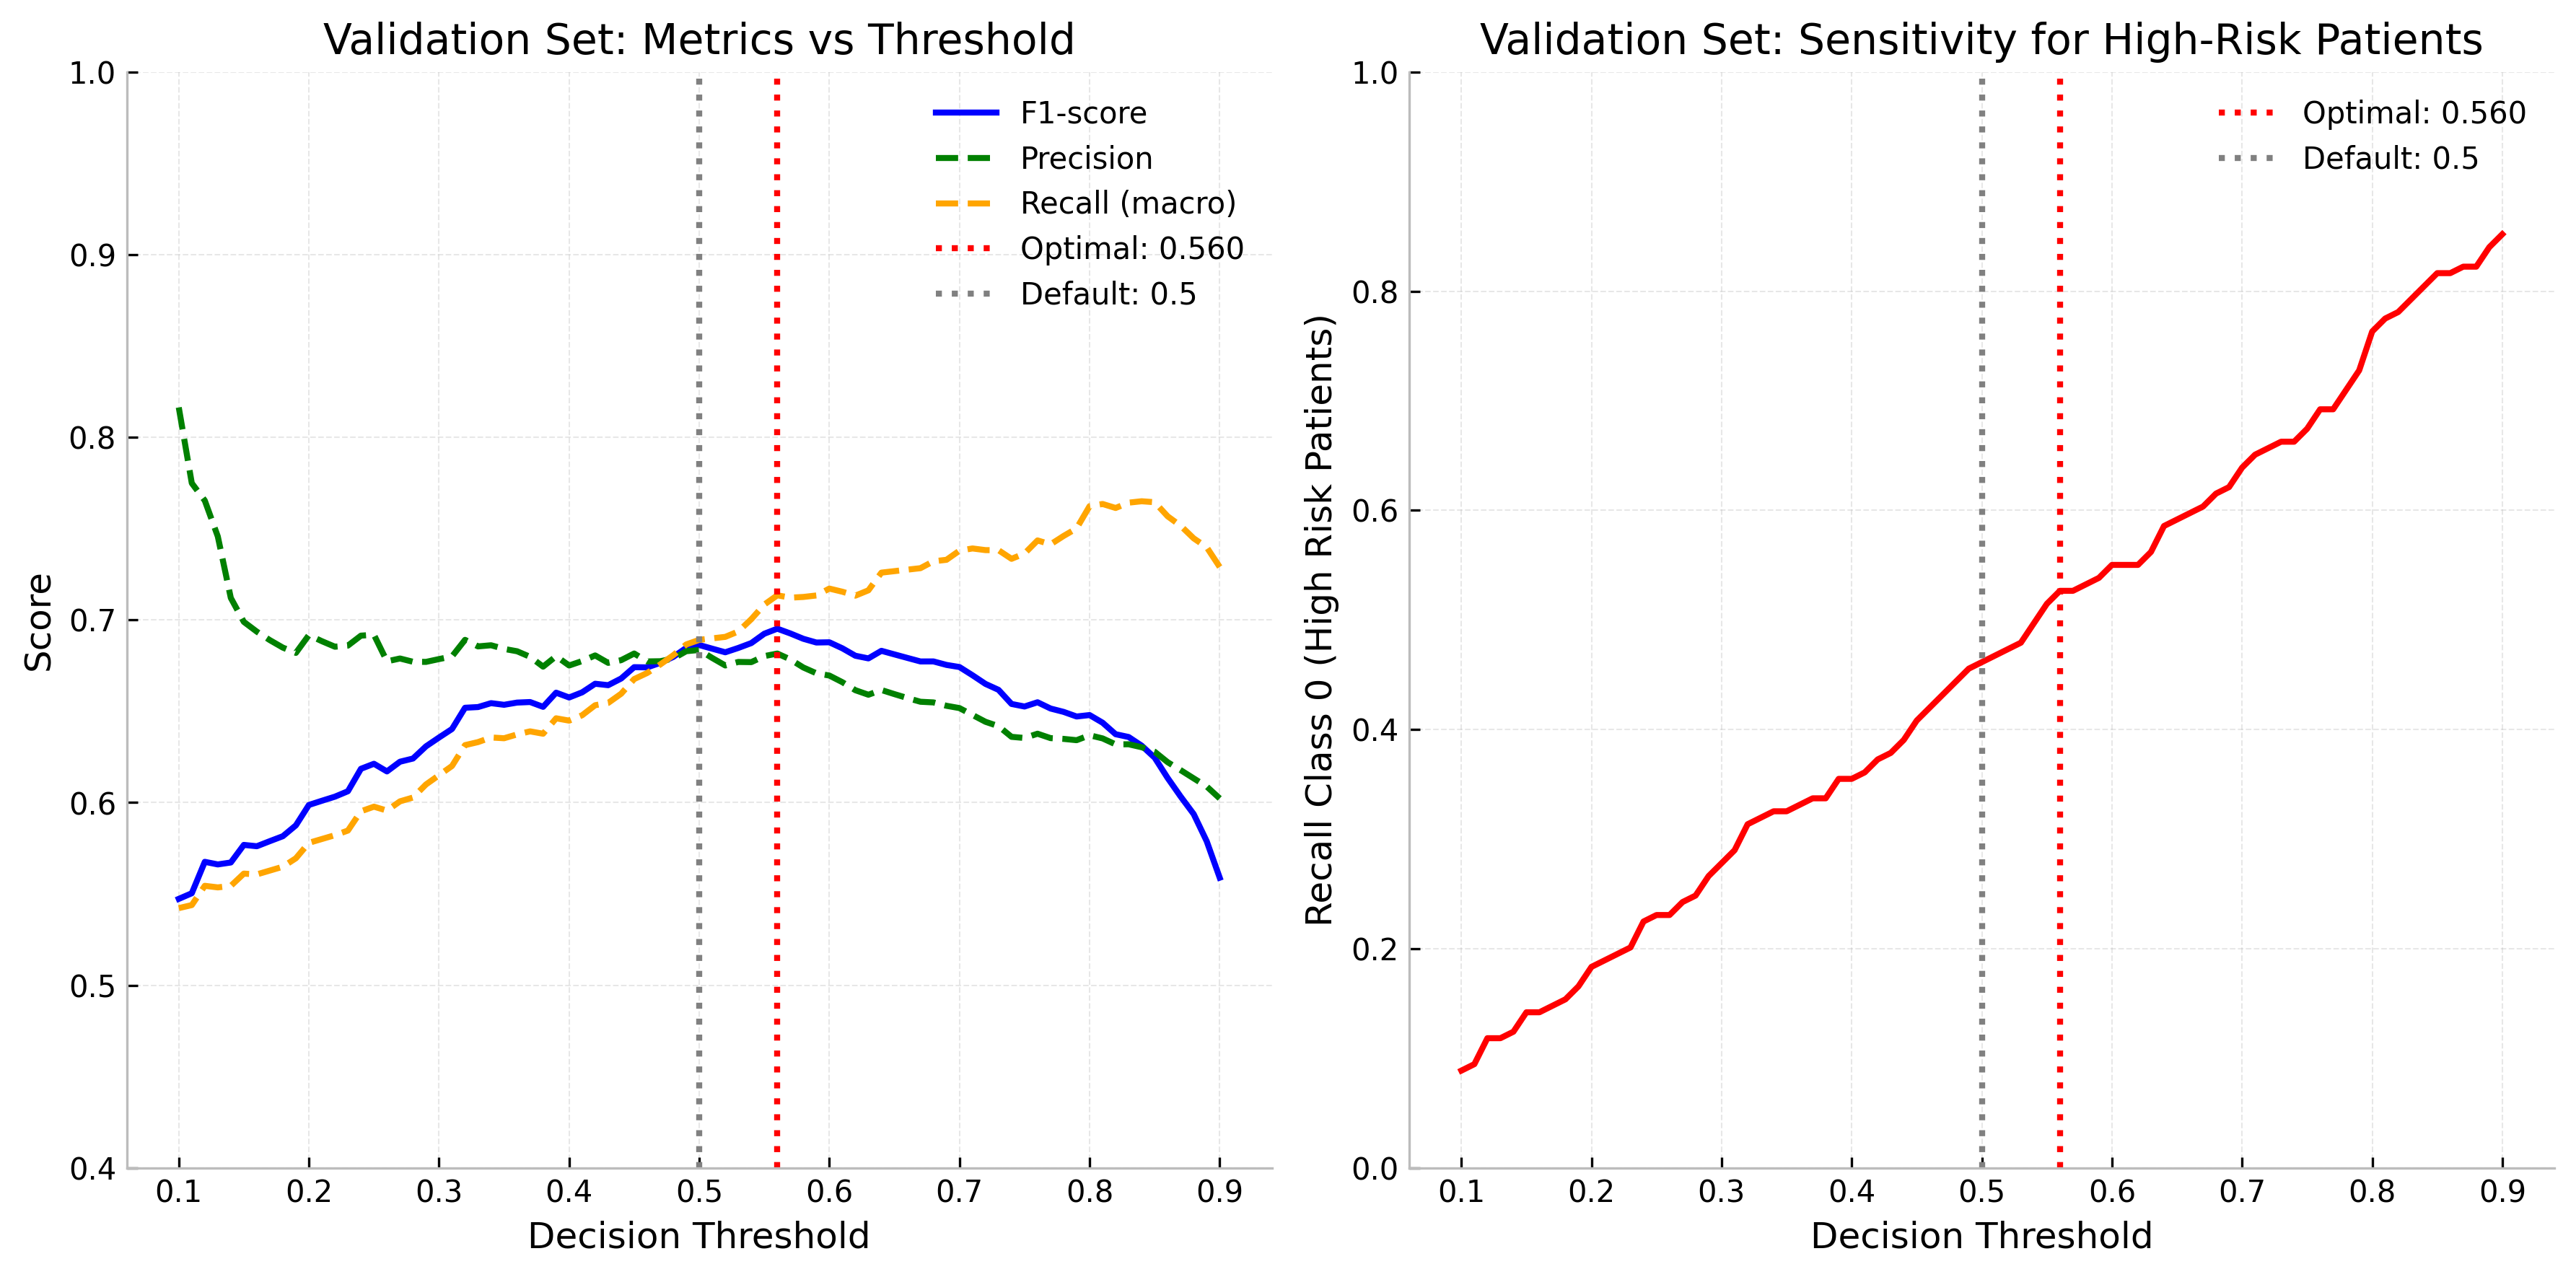

In [101]:
# Plot metrics vs threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_results['threshold'], df_results['f1'], label='F1-score', linewidth=2, color='blue')
plt.plot(df_results['threshold'], df_results['precision'], label='Precision', linestyle='--', color='green')
plt.plot(df_results['threshold'], df_results['recall'], label='Recall (macro)', linestyle='--', color='orange')
plt.axvline(x=best_threshold, color='red', linestyle=':', linewidth=2, label=f'Optimal: {best_threshold:.3f}')
plt.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default: 0.5')
plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Validation Set: Metrics vs Threshold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.4, 1.0])

plt.subplot(1, 2, 2)
plt.plot(df_results['threshold'], df_results['recall_class0'], linewidth=2, color='red')
plt.axvline(x=best_threshold, color='red', linestyle=':', linewidth=2, label=f'Optimal: {best_threshold:.3f}')
plt.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default: 0.5')
plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Recall Class 0 (High Risk Patients)', fontsize=12)
plt.title('Validation Set: Sensitivity for High-Risk Patients', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.0, 1.0])

plt.tight_layout()
plt.savefig(f"{path_images}threshold_optimization.png", dpi=300, bbox_inches='tight')
plt.show()

In [102]:
# ============================================================
# EVALUATION ON TEST SET WITH OPTIMAL THRESHOLD
# ============================================================

from sklearn.metrics import classification_report

print("\n" + "="*60)
print(f"TEST SET EVALUATION - OPTIMAL THRESHOLD ({best_threshold:.3f})")
print("="*60)

# Get test probabilities
test_prob, _ = predict_ensemble(ensemble, X_test, y_test)

# Predictions with optimal threshold
y_test_pred_optimal = (test_prob[:, 1] > best_threshold).astype(int)

# Predictions with default threshold
y_test_pred_default = (test_prob[:, 1] > 0.5).astype(int)

# Print detailed classification report
print("\nWith OPTIMAL threshold:")
print(classification_report(y_test, y_test_pred_optimal, digits=3))

# Calculate metrics
from sklearn.metrics import brier_score_loss
f1_optimal = f1_score(y_test, y_test_pred_optimal, average='macro')
auroc_optimal = roc_auc_score(y_test, test_prob[:, 1])  # AUC doesn't change
brier_optimal = brier_score_loss(y_test, test_prob[:, 1])  # Brier doesn't change
recall_class0_optimal = recall_score(y_test, y_test_pred_optimal, pos_label=0)

f1_default = f1_score(y_test, y_test_pred_default, average='macro')
recall_class0_default = recall_score(y_test, y_test_pred_default, pos_label=0)

print(f"\nTest Metrics with optimal threshold:")
print(f"F1 (macro):     {f1_optimal:.3f}")
print(f"AUC:            {auroc_optimal:.3f}")
print(f"Brier:          {brier_optimal:.3f}")
print(f"Recall Class 0: {recall_class0_optimal:.3f}")

print("\n" + "-"*60)
print("COMPARISON: Optimal vs Default Threshold")
print("-"*60)
print(f"{'Metric':<20} {'Threshold 0.5':>15} {'Optimal':>15} {'Improvement':>15}")
print("-"*60)
print(f"{'F1-score':<20} {f1_default:>15.3f} {f1_optimal:>15.3f} {f1_optimal-f1_default:>15.3f}")
print(f"{'Recall Class 0':<20} {recall_class0_default:>15.3f} {recall_class0_optimal:>15.3f} {recall_class0_optimal-recall_class0_default:>15.3f}")
print(f"{'Threshold':<20} {0.5:>15.3f} {best_threshold:>15.3f} {best_threshold-0.5:>15.3f}")
print("-"*60)

# Count how many more high-risk patients are identified
tp_optimal = np.sum((y_test == 0) & (y_test_pred_optimal == 0))
tp_default = np.sum((y_test == 0) & (y_test_pred_default == 0))
print(f"\nHigh-risk patients correctly identified:")
print(f"With threshold 0.5:  {tp_default}/{np.sum(y_test == 0)}")
print(f"With threshold {best_threshold:.2f}: {tp_optimal}/{np.sum(y_test == 0)} (+{tp_optimal - tp_default} patients)")


TEST SET EVALUATION - OPTIMAL THRESHOLD (0.560)

With OPTIMAL threshold:
              precision    recall  f1-score   support

         0.0      0.429     0.497     0.460       169
         1.0      0.925     0.904     0.914      1165

    accuracy                          0.852      1334
   macro avg      0.677     0.700     0.687      1334
weighted avg      0.862     0.852     0.857      1334


Test Metrics with optimal threshold:
F1 (macro):     0.687
AUC:            0.824
Brier:          0.100
Recall Class 0: 0.497

------------------------------------------------------------
COMPARISON: Optimal vs Default Threshold
------------------------------------------------------------
Metric                 Threshold 0.5         Optimal     Improvement
------------------------------------------------------------
F1-score                       0.690           0.687          -0.003
Recall Class 0                 0.450           0.497           0.047
Threshold                      0.500     

In [103]:
# Count confusion matrix elements
from sklearn.metrics import confusion_matrix

# Confusion matrix with default threshold
cm_default = confusion_matrix(y_test, y_test_pred_default)
tn_default, fp_default, fn_default, tp_default = cm_default.ravel()

# Confusion matrix with optimal threshold
cm_optimal = confusion_matrix(y_test, y_test_pred_optimal)
tn_optimal, fp_optimal, fn_optimal, tp_optimal = cm_optimal.ravel()

print("\n" + "="*60)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("Class 0 = CVD DEATH (HIGH RISK) - What we want to identify")
print("Class 1 = ALIVE (LOW RISK)")
print("="*60)

print("\nWith DEFAULT threshold (0.5):")
print(f"True Negatives (TN):   {tn_default:>4} - CVD Deaths correctly identified ✓")
print(f"False Positives (FP):  {fp_default:>4} - CVD Deaths missed (classified as alive) ✗✗")
print(f"False Negatives (FN):  {fn_default:>4} - Alive wrongly classified as CVD Death")
print(f"True Positives (TP):   {tp_default:>4} - Alive correctly identified")
print(f"\nTotal CVD Deaths (class 0):     {tn_default + fp_default}")
print(f"Total Alive patients (class 1): {fn_default + tp_default}")
print(f"\nSensitivity (Recall Class 0): {tn_default/(tn_default + fp_default):.3f} - % of CVD Deaths identified")
print(f"Specificity (Recall Class 1): {tp_default/(fn_default + tp_default):.3f} - % of Alive identified")

print(f"\nWith OPTIMAL threshold ({best_threshold:.3f}):")
print(f"True Negatives (TN):   {tn_optimal:>4} - CVD Deaths correctly identified ✓")
print(f"False Positives (FP):  {fp_optimal:>4} - CVD Deaths missed (classified as alive) ✗✗")
print(f"False Negatives (FN):  {fn_optimal:>4} - Alive wrongly classified as CVD Death")
print(f"True Positives (TP):   {tp_optimal:>4} - Alive correctly identified")
print(f"\nSensitivity (Recall Class 0): {tn_optimal/(tn_optimal + fp_optimal):.3f} - % of CVD Deaths identified")
print(f"Specificity (Recall Class 1): {tp_optimal/(fn_optimal + tp_optimal):.3f} - % of Alive identified")

print("\n" + "-"*60)
print("CHANGES: Optimal vs Default")
print("-"*60)
print(f"{'Metric':<35} {'Default':>10} {'Optimal':>10} {'Change':>10}")
print("-"*60)
print(f"{'CVD Deaths identified (TN)':<35} {tn_default:>10} {tn_optimal:>10} {tn_optimal - tn_default:>10}")
print(f"{'CVD Deaths MISSED (FP)':<35} {fp_default:>10} {fp_optimal:>10} {fp_optimal - fp_default:>10}")
print(f"{'False alarms (FN)':<35} {fn_default:>10} {fn_optimal:>10} {fn_optimal - fn_default:>10}")
print(f"{'Alive identified (TP)':<35} {tp_default:>10} {tp_optimal:>10} {tp_optimal - tp_default:>10}")
print("-"*60)

# Calculate sensitivity and specificity
sensitivity_default = tn_default / (tn_default + fp_default)
specificity_default = tp_default / (fn_default + tp_default)
sensitivity_optimal = tn_optimal / (tn_optimal + fp_optimal)
specificity_optimal = tp_optimal / (fn_optimal + tp_optimal)

print(f"\n{'Sensitivity (Recall Class 0)':<35} {sensitivity_default:>10.3f} {sensitivity_optimal:>10.3f} {sensitivity_optimal - sensitivity_default:>10.3f}")
print(f"{'Specificity (Recall Class 1)':<35} {specificity_default:>10.3f} {specificity_optimal:>10.3f} {specificity_optimal - specificity_default:>10.3f}")

# Clinical interpretation
print("\n" + "="*60)
print("CLINICAL INTERPRETATION")
print("="*60)

change_deaths_identified = tn_optimal - tn_default
change_deaths_missed = fp_optimal - fp_default
change_false_alarms = fn_optimal - fn_default

if change_deaths_identified > 0:
    print(f"✓ Identifies {change_deaths_identified} MORE CVD Deaths ({change_deaths_identified / (tn_default + fp_default) * 100:.1f}% of total)")
elif change_deaths_identified < 0:
    print(f"✗ Identifies {-change_deaths_identified} FEWER CVD Deaths ({-change_deaths_identified / (tn_default + fp_default) * 100:.1f}% of total)")
else:
    print(f"= Same number of CVD Deaths identified")

if change_deaths_missed < 0:
    print(f"✓ Misses {-change_deaths_missed} FEWER CVD Deaths (critical improvement!)")
elif change_deaths_missed > 0:
    print(f"✗ Misses {change_deaths_missed} MORE CVD Deaths (critical worsening!)")
else:
    print(f"= Same number of CVD Deaths missed")

if change_false_alarms > 0:
    print(f"✗ Generates {change_false_alarms} MORE false alarms ({change_false_alarms / (fn_default + tp_default) * 100:.1f}% of alive patients)")
elif change_false_alarms < 0:
    print(f"✓ Generates {-change_false_alarms} FEWER false alarms")
else:
    print(f"= Same number of false alarms")

# Trade-off summary
if change_deaths_identified != 0:
    print(f"\n{'='*60}")
    print("TRADE-OFF ANALYSIS")
    print(f"{'='*60}")
    if change_deaths_identified > 0:
        print(f"To identify {change_deaths_identified} more CVD Deaths,")
        print(f"we accept {change_false_alarms} more false alarms.")
        if change_deaths_identified > 0:
            print(f"Ratio: {change_false_alarms / change_deaths_identified:.2f} false alarms per additional death identified")
    else:
        print(f"By reducing false alarms by {-change_false_alarms},")
        print(f"we miss {-change_deaths_identified} more CVD Deaths.")


DETAILED CONFUSION MATRIX ANALYSIS
Class 0 = CVD DEATH (HIGH RISK) - What we want to identify
Class 1 = ALIVE (LOW RISK)

With DEFAULT threshold (0.5):
True Negatives (TN):     76 - CVD Deaths correctly identified ✓
False Positives (FP):    93 - CVD Deaths missed (classified as alive) ✗✗
False Negatives (FN):    87 - Alive wrongly classified as CVD Death
True Positives (TP):   1078 - Alive correctly identified

Total CVD Deaths (class 0):     169
Total Alive patients (class 1): 1165

Sensitivity (Recall Class 0): 0.450 - % of CVD Deaths identified
Specificity (Recall Class 1): 0.925 - % of Alive identified

With OPTIMAL threshold (0.560):
True Negatives (TN):     84 - CVD Deaths correctly identified ✓
False Positives (FP):    85 - CVD Deaths missed (classified as alive) ✗✗
False Negatives (FN):   112 - Alive wrongly classified as CVD Death
True Positives (TP):   1053 - Alive correctly identified

Sensitivity (Recall Class 0): 0.497 - % of CVD Deaths identified
Specificity (Recall Clas

In [104]:
##### from sklearn.calibration import calibration_curve
train_prob, train_pred = predict_ensemble(ensemble, X_train, y_train)
valid_prob, valid_pred = predict_ensemble(ensemble, X_valid, y_valid)
test_prob, test_pred = predict_ensemble(ensemble, X_test, y_test)
print(sum(y_train == train_pred) / len(df_train))
print(sum(y_valid == valid_pred) / len(df_valid))
print(sum(y_test == test_pred) / len(df_test))

df_train["ModelOutput"] = train_prob[:, 1]
df_valid["ModelOutput"] = valid_prob[:, 1]
df_test["ModelOutput"] = test_prob[:, 1]
extra_test_output = df_test[['ModelOutput']]
"""true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=1, 
         label='Ensemble')
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

# plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')"""
extra_test_output.to_csv(f"{path}extra_test_output.csv")
plt.savefig(f"{path_images}calibration1.png")

0.905726431607902
0.8590704647676162
0.8650674662668666


<Figure size 2400x1500 with 0 Axes>

In [105]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])
df_cvd["Elapsed"] = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_plot = df_test.join(df_cvd["Elapsed"])

assert len(df_plot) == len(df_test)

[0. 0. 0. ... 0. 0. 0.]


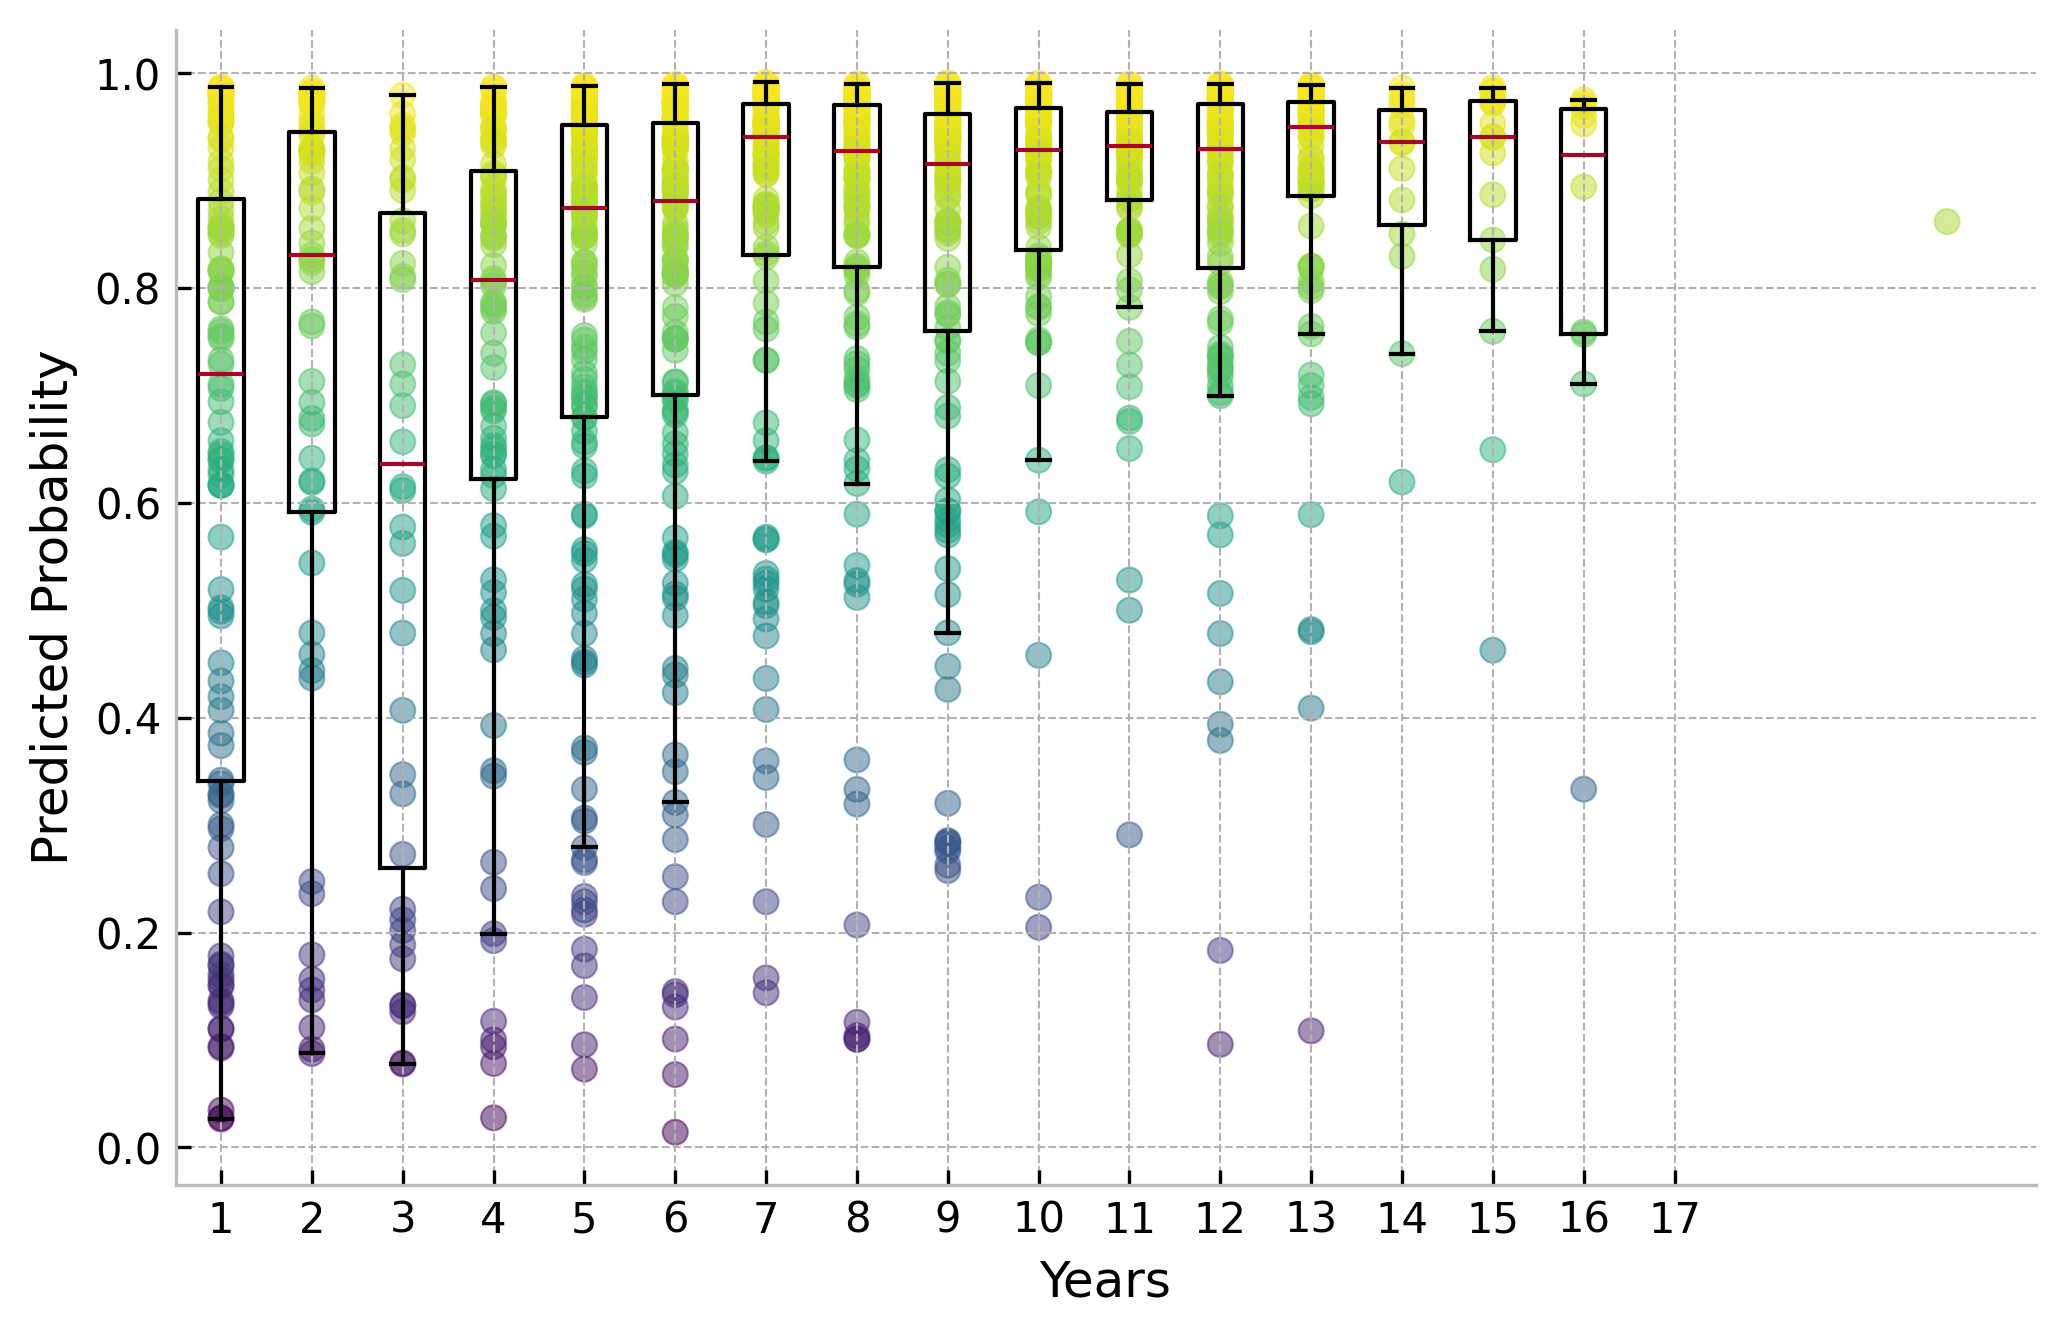

In [106]:
plt.figure(rasterized=True)
# group by years and take only the values
boxes = list(map(lambda x: list(x[1].values), list(df_plot.groupby("Elapsed")["ModelOutput"])))
boxes = boxes[:-1] + [[]]
plt.boxplot(boxes, showfliers=False)

n = 0.
noise = (np.random.rand(len(df_plot)) * n) - (n / 2)
print(noise)
#noise = 0
plt.scatter(df_plot["Elapsed"]+1+noise, df_plot["ModelOutput"], c=df_plot["ModelOutput"], alpha=0.5)

plt.xlabel("Years")
plt.ylabel("Predicted Probability")
# plt.xticks(range(18), [f"n={len(box)}" for box in boxes])
plt.savefig(f"{path_images}calibration.png")
#from PIL import Image
#png2 = Image.open("figures/calibration.png")
#png2.save("figures/calibration.tiff")

### Feature Ablation

In [107]:
from sklearn.inspection import permutation_importance
from utils import safe_feature_index

def get_univariate_ablation_results(X, y):
    """For each feature we set it to its mean value and save the resulting metrics"""

    features = list(df_valid.columns)
    del features[-2:]
    auroc, f1_macro = [], []
    for feature in range(len(features)):
        X_copy = X.copy()
        X_copy[:, feature] = X_copy[:, feature].mean()
        # Predict the ensemble with the values replaced with the mean
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        auroc.append((features[feature], round(roc_auc_score(y, y_proba[:, 1]), 3)))
        f1_macro.append((features[feature], round(f1_score(y, y_pred, average="macro"), 3)))
    
    return auroc, f1_macro


def get_multivariate_ablation_results(feat_clusters, X, y):
    """For each cluster of features, we set each feature of a group to its mean and save the resulting metrics"""

    auroc, f1_macro = [], []
    for feat_cluster in feat_clusters:
        # Create a copy of the dataset
        X_copy = X.copy()
        result = []
        for cluster in feat_cluster:
            # index = feat_names.index(cluster)
            index = safe_feature_index(cluster, feat_names)
            result.append(index)
            X_copy[:, index] = X_copy[:, index].mean()

        # Predict
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        auroc.append(round(roc_auc_score(y, y_proba[:, 1]), 3))
        f1_macro.append(round(f1_score(y, y_pred, average="macro"), 3))
    
    return auroc, f1_macro

In [108]:
# Univariate ablation
auroc, f1_macro = get_univariate_ablation_results(X_test, y_test)
ensemble_f1_score = round(f1_score(y_test, test_pred, average="macro"), 3)
p = pd.DataFrame({
    "auroc": [x[1] for x in auroc], 
    "f1_macro": [x[1] for x in f1_macro],
    "importance" : [ ensemble_f1_score / x[1] for x in f1_macro],
    }, index=feat_names[:-1]).sort_values("importance",ascending = False)
p.to_csv(f"{path_images}extra_ablation_uni_test.csv", float_format = '%.5f')

In [109]:
# Multivariate hierarchical ablation
ensemble_f1_score = round(f1_score(y_test, test_pred, average="macro"), 3)
with open(f"{path_images}feat_cluster_hier.df", "rb") as f:
    df_clusters = pickle.load(f)
print(df_clusters)
auroc, f1_macro = get_multivariate_ablation_results(df_clusters, X_test, y_test)
p = pd.DataFrame({"cluster": df_clusters, "auroc": auroc, "f1_macro": f1_macro, "importance" : [ ensemble_f1_score / x for x in f1_macro] })
p.to_csv(f"{path_images}multivariate_ablation_hier_nomeds.csv", float_format = '%.5f')

0                             [Diabetes, Hypertension]
1    [Angina, Angiography, Vessels, Documented rest...
2                           [Age, Atrial Fibrillation]
3                                      [Gender, Smoke]
4    [Previous CABG, PCI, Previous MI, Post IDC, LVEF]
5                                           [Acute MI]
Name: Feature, dtype: object


In [110]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)

<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_0/exported_notebooks/3_ensemble_ablations_18features_20251013_094510.html
